<a href="https://colab.research.google.com/github/francescopatane96/Bioactivity-prediction-with-ML/blob/main/ML7up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 263 kB/s 


In [6]:
!pip install git+https://github.com/volkamerlab/teachopencadd.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/volkamerlab/teachopencadd.git to /tmp/pip-req-build-lvf6odzi
  Running command git clone -q https://github.com/volkamerlab/teachopencadd.git /tmp/pip-req-build-lvf6odzi
  Created wheel for teachopencadd: filename=teachopencadd-2022.9.0+2.g8f2c87a-py3-none-any.whl size=108231919 sha256=50725aed4ce8dee79b4c289998ec6b1c5bd81a15b44e7e5c5295bda05bec02bc
  Stored in directory: /tmp/pip-ephem-wheel-cache-stam_fbk/wheels/ee/da/82/b2c07c8ddbf7e09a56a283a394ebff26d956480b85a9ef011f
Successfully built teachopencadd


In [7]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

In [8]:
# Read data from previous talktorials
chembl_df = pd.read_csv(
    "TNFB_compounds_lipinski.csv",
    index_col=0,
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()


Shape of dataframe :  (49, 11)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL336546,50.0,nM,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030,"<img data-content=""rdkit/molecule"" src=""data:i...",436.997743,3,1,5.4387,True
1,CHEMBL131636,170.0,nM,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551,"<img data-content=""rdkit/molecule"" src=""data:i...",469.062788,5,1,5.3768,True
2,CHEMBL134490,280.0,nM,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842,"<img data-content=""rdkit/molecule"" src=""data:i...",441.031488,5,1,4.5966,True
3,CHEMBL135133,380.0,nM,O=C(Nc1ccc(C(F)(F)F)cc1)c1cnc(Cl)nc1C(F)(F)F,6.420216,"<img data-content=""rdkit/molecule"" src=""data:i...",369.010359,3,1,4.4199,True
4,CHEMBL334485,500.0,nM,O=C(Nc1cc(Cl)cc(Cl)c1)c1cnc(Cl)nc1C(F)(F)F,6.301030,"<img data-content=""rdkit/molecule"" src=""data:i...",368.945029,3,1,4.7079,True


In [9]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()


,molecule_chembl_id,smiles,pIC50
0,CHEMBL336546,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030
1,CHEMBL131636,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551
2,CHEMBL134490,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842
3,CHEMBL135133,O=C(Nc1ccc(C(F)(F)F)cc1)c1cnc(Cl)nc1C(F)(F)F,6.420216
4,CHEMBL334485,O=C(Nc1cc(Cl)cc(Cl)c1)c1cnc(Cl)nc1C(F)(F)F,6.301030


In [10]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 6.3].index, "active"] = 1.0

# NBVAL_CHECK_OUTPUT
print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 5
Number of inactive compounds: 44


In [11]:
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL336546,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030,1.0
1,CHEMBL131636,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551,1.0
2,CHEMBL134490,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842,1.0
3,CHEMBL135133,O=C(Nc1ccc(C(F)(F)F)cc1)c1cnc(Cl)nc1C(F)(F)F,6.420216,1.0
4,CHEMBL334485,O=C(Nc1cc(Cl)cc(Cl)c1)c1cnc(Cl)nc1C(F)(F)F,6.301030,1.0


In [12]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [16]:
# Add column for fingerprint
chembl_df["fp"] = chembl_df["smiles"].apply(smiles_to_fp)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL336546,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL131636,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL134490,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [18]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [19]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [21]:
fingerprint_to_model = chembl_df.fp.tolist()
label_to_model = chembl_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 39
Test data size: 10


In [22]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [23]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.50
Specificity: 0.88
AUC: 0.88


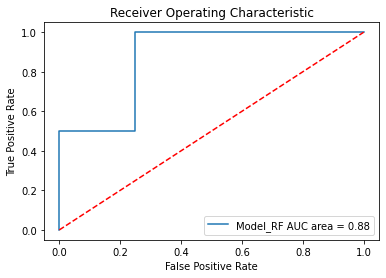

In [24]:
# Initialize the list that stores all models. First one is RF.
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [25]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.00
Specificity: 1.00
AUC: 0.06


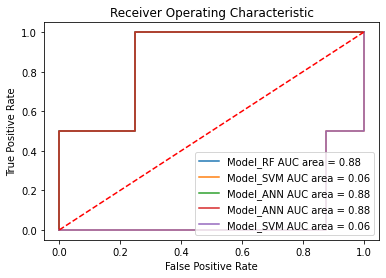

In [30]:
# Append SVM model
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [27]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.00
Specificity: 1.00
AUC: 0.88


NameError: ignored

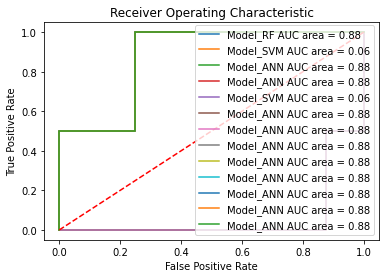

In [38]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True)

In [39]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [40]:
N_FOLDS = 3

In [42]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], chembl_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.84 	and std : 0.03 
Mean sensitivity: 0.50 	and std : 0.41 
Mean specificity: 0.89 	and std : 0.08 
Mean AUC: 0.91 	and std : 0.08 
Time taken : 0.54s


Model_SVM
Mean accuracy: 0.86 	and std : 0.03 
Mean sensitivity: 0.00 	and std : 0.00 
Mean specificity: 0.96 	and std : 0.06 
Mean AUC: 0.54 	and std : 0.36 
Time taken : 0.03s


Model_ANN
Mean accuracy: 0.90 	and std : 0.03 
Mean sensitivity: 0.00 	and std : 0.00 
Mean specificity: 1.00 	and std : 0.00 
Mean AUC: 0.90 	and std : 0.08 
Time taken : 0.46s


Model_ANN
Mean accuracy: 0.90 	and std : 0.03 
Mean sensitivity: 0.00 	and std : 0.00 
Mean specificity: 1.00 	and std : 0.00 
Mean AUC: 0.90 	and std : 0.08 
Time taken : 0.45s


Model_SVM
Mean accuracy: 0.86 	and std : 0.03 
Mean sensitivity: 0.00 	and std : 0.00 
Mean specificity: 0.96 	and std : 0.06 
Mean AUC: 0.85 	and std : 0.08 
Time taken : 0.02s


Model_ANN
Mean accuracy: 0.90 	and std : 0.03 
Mean sensitivity: 0.00 	and std : 0.00 
Mean specific

In [43]:
# Reset data frame
compound_df = chembl_df.copy()

In [44]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL336546,O=C(Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1)c1cnc(Cl)nc1...,7.301030,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL131636,CCCCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C...,6.769551,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,CHEMBL134490,CCOC(=O)c1cc(NC(=O)c2cnc(Cl)nc2C(F)(F)F)cc(C(F...,6.552842,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [45]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        continue
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.86 	and std : 0.03 
Mean sensitivity: 0.33 	and std : 0.47 
Mean specificity: 0.93 	and std : 0.09 
Mean AUC: 0.96 	and std : 0.03 
Time taken : 0.52s


Model_ANN
Mean accuracy: 0.80 	and std : 0.13 
Mean sensitivity: 1.00 	and std : 0.00 
Mean specificity: 0.78 	and std : 0.14 
Mean AUC: 0.94 	and std : 0.04 
Time taken : 1.37s


Model_ANN
Mean accuracy: 0.80 	and std : 0.13 
Mean sensitivity: 1.00 	and std : 0.00 
Mean specificity: 0.78 	and std : 0.14 
Mean AUC: 0.94 	and std : 0.04 
Time taken : 1.09s


Model_ANN
Mean accuracy: 0.80 	and std : 0.13 
Mean sensitivity: 1.00 	and std : 0.00 
Mean specificity: 0.78 	and std : 0.14 
Mean AUC: 0.94 	and std : 0.04 
Time taken : 1.15s


Model_ANN
Mean accuracy: 0.80 	and std : 0.13 
Mean sensitivity: 1.00 	and std : 0.00 
Mean specificity: 0.78 	and std : 0.14 
Mean AUC: 0.94 	and std : 0.04 
Time taken : 1.29s


Model_ANN
Mean accuracy: 0.80 	and std : 0.13 
Mean sensitivity: 1.00 	and std : 0.00 
Mean specific